<h1 ><big><center>Object recognition and computer vision 2018/2019</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>


<h2><big><center> Assignment 2: Neural networks</center></big></h2>

<h5><big><center>Adapted from practicals from <a href="http://nicolas.le-roux.name/">Nicolas le Roux</a>, 
  <br><a href="http://www.robots.ox.ac.uk/~vgg/practicals/overview/index.html">Andrea Vedaldi and Andrew Zisserman</a> and <a href="https://cs.nyu.edu/~fergus/teaching/vision/">Rob Fergus</a>
  <br> by <a href="https://www.di.ens.fr/~varol/">Gul Varol</a> and <a href="https://www.di.ens.fr/~iroccosp/">Ignacio Rocco</a></center></big></h5>


</br>

<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis/assignment3/images/fullyconn.png"/></p>
<p align="center">Figure 1</p>
<p align="center"></p>

**STUDENT**:  Benjamin LAZARD

**EMAIL**:  benjamin.lazard@polytechnique.edu

# Goal


The goal of this assignment is to get basic knowledge and hands-on experience with training and using neural networks. In Part 1 of the assignment you will implement and experiment with the training and testing of a simple two layer fully-connected neural network, similar to the one depicted in Figure 1 above. In Part 2 you will learn about convolutional neural networks, their motivation, building blocks, and how they are trained. Finally, in part 3 you will train a CNN for classification using the CIFAR-10 dataset.

# Part 1 - Training a fully connected neural network

## Getting started

You will be working with a two layer neural network of the following form 

\begin{equation}
H=\text{ReLU}(W_i X+B_i)\\
Y=W_oH+B_o
\tag{1}
\end{equation}

where $X$ is the input, $Y$ is the output, $H$ is the hidden layer, and $W_i$, $W_o$, $B_i$ and $B_o$ are the network parameters that need to be trained. Here the subscripts $i$ and $o$ stand for the *input* and *output* layer, respectively. This network was also discussed in the class and is illustrated in the above figure where the input units are shown in green, the hidden units in blue and the output in yellow. This network is implemented in the function `nnet_forward_logloss`.

You will train the parameters of the network from labelled training data $\{X^n,Y^n\}$ where $X^n$ are points in $\mathbb{R}^2$ and $Y^n\in\{-1,1\}$ are labels for each point. You will use the stochastic gradient descent algorithm discussed in the class to minimize the loss of the network on the training data given by 

\begin{equation}
L=\sum_n s(Y^n,\bar{Y}(X^n))
\tag{2}
\end{equation}

where $Y^n$ is the target label for the n-th example and $\bar{Y}(X^n)$ is the network’s output for the n-th example $X^n$. The skeleton of the training procedure is provided in the `train_loop` function. 

We will use the logistic loss, which has the following form:

\begin{equation}
s(Y, \bar{Y}(X))=\log(1+\exp(-Y. \bar{Y}(X))
\tag{3}
\end{equation}

where $Y$ is the target label and $\bar{Y}(X)$ is the output of the network for input example $X$. With the logistic loss, the output of the network can be interpreted as a probability $P(\text{class}=1|X) =\sigma(X)$ , where $\sigma(X) =1/(1+\exp(-X))$ is the sigmoid function. Note also that $P(\text{class}=-1|X)=1-P(\text{class}=1|X)$.

In [200]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
#%matplotlib notebook


def decision_boundary_nnet(X, Y, Wi, bi, Wo, bo):
    x_min, x_max = -2, 4
    y_min, y_max = -5, 3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                     np.arange(y_min, y_max, .05))

    XX = np.vstack((xx.ravel(), yy.ravel())).T
    input_hidden = np.dot(XX, Wi) + bi
    hidden = np.maximum(input_hidden, 0)
    Z = np.dot(hidden, Wo) + bo

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z > 0, cmap=plt.cm.Paired)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='winter')
    plt.axis([-2, 4, -5, 3])
    plt.draw()


def sigm(x):
    # Returns the sigmoid of x.
    small_x = np.where(x < -20)  # Avoid overflows.
    sigm_x = 1/(1 + np.exp(-x))
    if type(sigm_x) is np.ndarray:
        sigm_x[small_x] = 0.0
    return sigm_x


def nnet_forward_logloss(X, Y, Wi, bi, Wo, bo):
    '''
    Compute the output Po, Yo and the loss of the network for the input X
    This is a 2 layer (1 hidden layer network)

    Input:
        X ... (in R^2) set of input points, one per column
        Y ... {-1,1} the target values for the set of points X
        Wi, bi, Wo, bo ... parameters of the network

    Output: 
       Po ... probabilisitc output of the network P(class=1 | x) 
                  Po is in <0 1>. 
                  Note: P(class=-1 | x ) = 1 - Po
       Yo ... output of the network Yo is in <-inf +inf>
       loss ... logistic loss of the network on examples X with ground target
                    values Y in {-1,1}
    '''
    # Hidden layer
    hidden = np.maximum(np.dot(X, Wi) + bi, 0)
    # Output of the network
    Yo = np.dot(hidden, Wo) + bo
    # Probabilistic output
    Po = sigm(Yo)
    # Logistic loss
    loss = np.log(1 + np.exp( -Y * Yo)) 
    return Po, Yo, loss


# Load the training data
!wget -q http://www.di.ens.fr/willow/teaching/recvis18/assignment2/double_moon_train1000.mat
train_data = sio.loadmat('./double_moon_train1000.mat', squeeze_me=True)
Xtr = train_data['X']
Ytr = train_data['Y']
# Load the validation data
!wget -q http://www.di.ens.fr/willow/teaching/recvis18/assignment2/double_moon_val1000.mat
val_data = sio.loadmat('./double_moon_val1000.mat', squeeze_me=True)
Xval = val_data['X']
Yval = val_data['Y']

## Computing gradients of the loss with respect to network parameters 

Let us derive the form of the gradient of the logistic loss (3) with respect to the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$.

### A few reminders: 
- Equations at hand:
$
\begin{align}
H &=\text{ReLU}(W_i X+B_i)\\
\hat{Y} &= W_oH+B_o
\tag{1}
\end{align}
$
- key parameters:
    - $n$ : number of observations
    - $d_i = 2$: dimension of the input space for each observation $X_i$
    - $d_o = 1$: dimension of the output space for each label $Y_i$
    - $h$: dimension of the hidden layer (number of neurons in it)
- Dimensions of the matrixes (because of computer constraints, mathematical vectors are sometimes vertical, sometimes horizontal):
    - $X \rightarrow (d_i, 1)$
    - $Y \rightarrow (d_o, 1)$
    - $B_o \rightarrow (d_o, 1)$
    - $W_o \rightarrow (d_o, h)$
    - $B_i \rightarrow (h, 1)$
    - $W_i \rightarrow (h, d_i)$
- Chain Rule: 
$$\frac{\partial g(f(x))}{\partial x} = \frac{\partial g(f(x))}{\partial f(x)} \frac{\partial f(x)}{\partial x} = g'\big(f(x)\big) \;\, f'(x)$$

- Derivative of *ReLU* function:
$$\text{ReLU}(x) = max(0, x) \Longrightarrow \text{ReLU}'(x) = \mathbb{1}_{\mathbb{R}_+}(x)$$

### Derivatives: 

For any parameter $\alpha \in \{B_o, W_o, B_i, W_i\}: \frac{\partial s(Y, \hat{Y})}{\partial \alpha} = \frac{\partial s(Y, \hat{Y})}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial \alpha}$

We have:
- $\frac{\partial s(Y, \hat{Y})}{\partial \hat{Y}} = 
\frac{\partial log\left(1 + e^{-Y\hat{Y}}\right)}{\partial \hat{Y}}
= \frac{\partial \left(1 + e^{-Y\hat{Y}}\right)}{\partial \hat{Y}} \frac{1}{1 + e^{-Y\hat{Y}}}
= \frac{-Ye^{-Y\hat{Y}}}{1 + e^{-Y\hat{Y}}}
= \frac{-Y}{1+e^{Y\hat{Y}}}$

- $\frac{\partial \hat{Y}}{\partial B_o} = \frac{\partial W_o H + B_o}{\partial B_o} = 1$
- $\frac{\partial \hat{Y}}{\partial W_o} = \frac{\partial W_o H + B_o}{\partial W_o} = H^T$
- $\frac{\partial \hat{Y}}{\partial B_i} = \frac{\partial W_o \text{ReLU}(W_i X+B_i)+ B_o}{\partial B_i} = W_o^T.\mathbb{1}_{\mathbb{R}_+}(W_i X+B_i)$
- $\frac{\partial \hat{Y}}{\partial W_i} = \frac{\partial W_o \text{ReLU}(W_i X+B_i)+ B_o}{\partial W_i} = \left[W_o^T.\mathbb{1}_{\mathbb{R}_+}(W_i X+B_i)\right] \times X^T$


In [187]:
def gradient_nn(X, Y, Wi, bi, Wo, bo):
    '''
    Compute gradient of the logistic loss of the neural network on example X with
    target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
        X ... dx1 vector of the input example
        Y ... 1x1 the target label in {-1,1}   
        Wi,bi,Wo,bo ... parameters of the network
        Wi ... [hxd]
        bi ... [hx1]
        Wo ... [1xh]
        bo ... 1x1
        where h... is the number of hidden units
              d... is the number of input dimensions (d=2)

    Output: 
        grad_s_Wi [hxd] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
        grad_s_Wo [1xh] ... gradient of loss s(Y,Y(X)) w.r.t. Wo
        grad_s_bi [hx1] ... gradient of loss s(Y,Y(X)) w.r.t. bi
        grad_s_bo [1x1] ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''
    
    #############################################
    # Forward pass
    #############################################
    # Hidden layer
    H = np.dot(X, Wi) + bi
    hidden = np.maximum(H, 0)
    # Output of the network
    Yo = np.dot(hidden, Wo) + bo
    
    #############################################
    # Backward pass
    #############################################
    
    #common factor
    coef = -Y / (1. + np.exp(Y * Yo))
    
    #output parameters
    grad_s_bo = coef
    grad_s_Wo = coef * hidden
    
    #Input parameters
    H_mask = Wo.T * (H > 0)
    grad_s_bi = coef *  H_mask
    
    grad_s_Wi = coef *  H_mask
    grad_s_Wi = np.dot(X.T, grad_s_Wi)

    return grad_s_Wi, grad_s_Wo, grad_s_bi, grad_s_bo

## Numerically verifying the gradients
Let us check numerically that the analytically computed gradients in `gradient_nn` are correct. 

We can numerically approximate the derivatives using the definition of the derivative:

With $\Delta \theta $ being the vector $0_d$, except for a small value $\epsilon \in \mathbb{R}_+$ at line $i$:
$\frac{s(\theta + \Delta \theta) - s(\theta)}{\epsilon} \underset{\epsilon \rightarrow 0}{\longrightarrow} \frac{\partial s(\theta)}{\partial \theta_i}$

Following the general formula, `gradient_nn_numerical` function numerically computes the derivatives of the loss function with respect to all the parameters of the network $W_i$, $W_o$, $B_i$ and $B_o$:

In [188]:
def gradient_nn_numerical(X, Y, Wi, bi, Wo, bo):
    '''
    Compute numerical gradient of the logistic loss of the neural network on
    example X with target label Y, with respect to the parameters Wi,bi,Wo,bo.

    Input:
       X ... 2x1 vector of the input example
       Y ... 1x1 the target label in {-1,1}   
       Wi, bi, Wo, bo ... parameters of the network
       Wi ... [hxd]
       bi ... [hx1]
       Wo ... [1xh]
       bo ... 1x1
       where h... is the number of hidden units
             d... is the number of input dimensions (d=2)

    Output: 
       grad_s_Wi_numerical [hxd] ... gradient of loss s(Y,Y(X)) w.r.t  Wi
       grad_s_Wo_numerical [1xh] ... gradient of loss s(Y,Y(X)) w.r.t. Wo
       grad_s_bi_numerical [hx1] ... gradient of loss s(Y,Y(X)) w.r.t. bi
       grad_s_bo_numerical [1x1] ... gradient of loss s(Y,Y(X)) w.r.t. bo
    '''

    eps = 1e-8
    grad_s_Wi_numerical = np.zeros(Wi.shape)
    grad_s_bi_numerical = np.zeros(bi.shape)
    grad_s_Wo_numerical = np.zeros(Wo.shape)

    for i in range(Wi.shape[0]):
        for j in range(Wi.shape[1]):
            dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, +eps), bi, Wo, bo)
            dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, sumelement_matrix(Wi, i, j, -eps), bi, Wo, bo)
            grad_s_Wi_numerical[i, j] = (pos_loss - neg_loss)/(2*eps)

    for i in range(bi.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, +eps), Wo, bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, sumelement_vector(bi, i, -eps), Wo, bo)
        grad_s_bi_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    for i in range(Wo.shape[0]):
        dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, +eps), bo)
        dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, sumelement_vector(Wo, i, -eps), bo)
        grad_s_Wo_numerical[i] = (pos_loss - neg_loss)/(2*eps)

    dummy, dummy, pos_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo+eps)
    dummy, dummy, neg_loss = nnet_forward_logloss(X, Y, Wi, bi, Wo, bo-eps)
    grad_s_bo_numerical = (pos_loss - neg_loss)/(2*eps)

    return grad_s_Wi_numerical, grad_s_Wo_numerical, grad_s_bi_numerical, grad_s_bo_numerical


def sumelement_matrix(X, i, j, element):
    Y = np.copy(X)
    Y[i, j] = X[i, j] + element
    return Y


def sumelement_vector(X, i, element):
    Y = np.copy(X)
    Y[i] = X[i] + element
    return Y

`gradcheck` function checks that the analytically computed derivative using function `gradient_nn` (e.g. `grad_s_bo`) at the same training example $\{X,Y\}$ is the same (up to small errors) as your numerically computed value of the derivative using function `gradient_nn_numerical` (e.g. `grad_s_bo_numerical`). Make sure the output is `SUCCESS` to move on to the next task.

In [189]:
def gradcheck():
    '''
    Check that the numerical and analytical gradients are the same up to eps
    '''
    h = 3 # number of hidden units
    eps = 1e-6
    for i in range(1000):
        # Generate random input/output/weight/bias
        X  = np.random.randn(1, 2)
        Y  = 2* np.random.randint(2) - 1 # {-1, 1}
        Wi = np.random.randn(X.shape[1], h)
        Wo = np.random.randn(h)
        bi = np.random.randn(h)
        bo = np.random.randn(1)
        # Compute analytical gradients
        grad_s_Wi, grad_s_Wo, grad_s_bi, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)
        # Compute numerical gradients
        grad_s_Wi_numerical, grad_s_Wo_numerical, grad_s_bi_numerical, grad_s_bo_numerical = gradient_nn_numerical(X, Y, Wi, bi, Wo, bo)
        # Compute the difference between analytical and numerical gradients
        delta_Wi = np.mean(np.abs(grad_s_Wi - grad_s_Wi_numerical))
        delta_Wo = np.mean(np.abs(grad_s_Wo - grad_s_Wo_numerical))
        delta_bi = np.mean(np.abs(grad_s_bi - grad_s_bi_numerical))
        delta_bo = np.abs(grad_s_bo - grad_s_bo_numerical)
        # Difference larger than a threshold
        if ( delta_Wi > eps or delta_Wo > eps or delta_bi > eps or delta_bo > eps):
            print("At iteration i = ", i)
            print("delta_bo = ", delta_bo, "\n", 
                 "delta_Wo = ", delta_Wo, "\n",
                 "delta_bi = ", delta_bi, "\n",
                 "delta_Wi = ", delta_Wi)
            return False

    return True 


# Check gradients
if gradcheck():
    print('SUCCESS: Passed gradcheck.')
else:
    print('FAILURE: Fix gradient_nn and/or gradient_nn_aprox implementation.')

SUCCESS: Passed gradcheck.


## Training the network using backpropagation and experimenting with different parameters

Let us run the algorithm, and see the decision boundary, and errors throughout iterations.

Show also the evolution of the training and validation errors. Include the decision hyper-plane visualization and the training and validation error plots.

In [225]:
def train_loop(Xtr, Ytr, Xval, Yval, 
               h, lrate, 
               vis='all', 
               nEpochs=100, ϵ=1e-8):
    '''
    Check that the numerical and analytical gradients are the sae up to eps

    Input:
        Xtr ... Nx2 matrix of training samples
        Ytr ... N dimensional vector of training labels
        Xval ... Nx2 matrix of validation samples 
        Yval ... N dimensional vector validation labels
        h ... number of hidden units
        lrate ... learning rate
        vis ... visulaization option ('all' | 'last' | 'never')
        nEpochs ... number of training epochs

    Output:
        tr_error ... nEpochs*nSamples dimensional vector of training error
        val_error ... nEpochs*nSamples dimensional vector of validation error
    '''

    nSamples = Xtr.shape[0]
    tr_error = np.zeros(nEpochs*nSamples)
    val_error = np.zeros(nEpochs*nSamples)
    
    #Initialization
    Wi = np.random.randn(Xtr.shape[1], h)
    Wo = np.zeros(h)
    bi = np.zeros(h)
    bo = 0.

    if(vis == 'all' or vis == 'last'):
        plt.figure(figsize=(16,5))

    for i in range(nEpochs*nSamples):
        # Draw an example at random
        n = np.random.randint(nSamples)
        X = Xtr[n].reshape(-1,1).T
        Y = Ytr[n]

        # Compute gradient 
        grad_s_Wi, grad_s_Wo, grad_s_bi, grad_s_bo = gradient_nn(X, Y, Wi, bi, Wo, bo)

        # Gradient update
        Wi -= lrate*grad_s_Wi
        Wo -= lrate*grad_s_Wo[0]
        bi -= lrate*grad_s_bi[0]
        bo -= lrate*grad_s_bo

        # Compute training error
        Po, Yo, loss    = nnet_forward_logloss(Xtr, Ytr, Wi, bi, Wo, bo)
        Yo_class        = np.sign(Yo)
        tr_error[i]     = 100*np.mean(Yo_class != Ytr)

        # Compute validation error
        Pov, Yov, lossv = nnet_forward_logloss(Xval, Yval, Wi, bi, Wo, bo)
        Yov_class       = np.sign(Yov)
        val_error[i]    = 100*np.mean(Yov_class != Yval)

        # Plot (at every epoch if visualization is 'all', only at the end if 'last')
        if(vis == 'all' and i%nSamples == 0) or (vis == 'last' and i == nEpochs*nSamples - 1):
            # Draw the decision boundary.
            plt.clf()
            plt.title('p = %d, Iteration = %.d, Error = %.3f' % (h, i/nSamples, tr_error[i]))
            decision_boundary_nnet(Xtr, Ytr, Wi, bi, Wo, bo)
            display.display(plt.gcf(), display_id=True)
            display.clear_output(wait=True)
            
        #Stop if error is really small
        if max(tr_error[i],val_error[i])  < ϵ and i%nSamples == 0:
            break

    if(vis == 'all'):
        # Plot the evolution of the training and test errors
        plt.figure(figsize=(16,5))
        plt.plot(tr_error[:i], label='training')
        plt.plot(val_error[:i], label='validation')
        plt.legend()
        plt.title('Training/validation errors: %.2f%% / %.2f%%' % (tr_error[i], val_error[i]))
        
    return tr_error, val_error

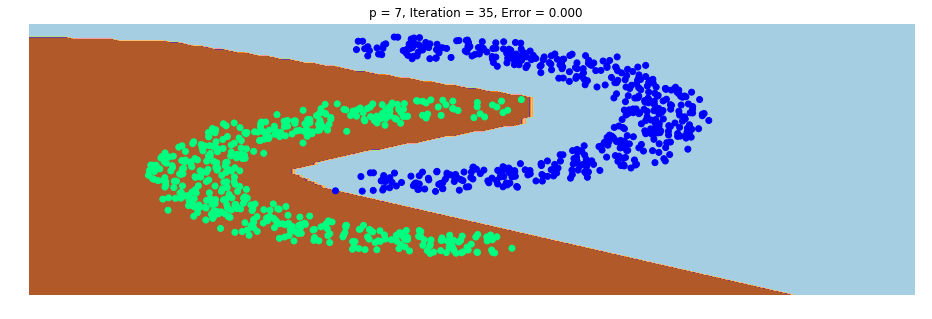

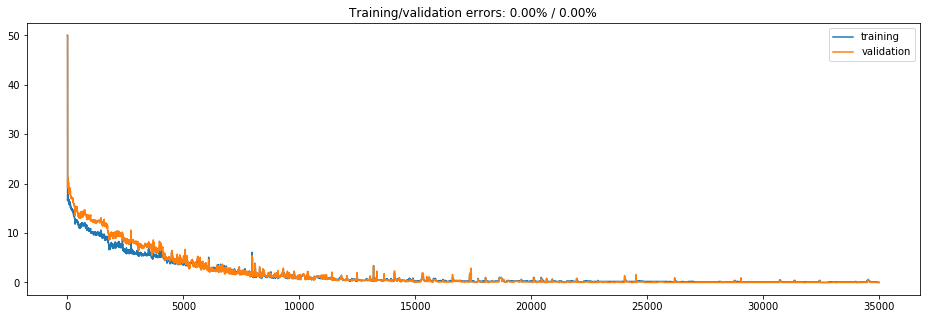

In [223]:
# Run training
h = 7
lrate = .02
tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate)

### Impact of the initialization:

**Random initializations.** Let us repeat the procedure 5 times, and compare the final error.

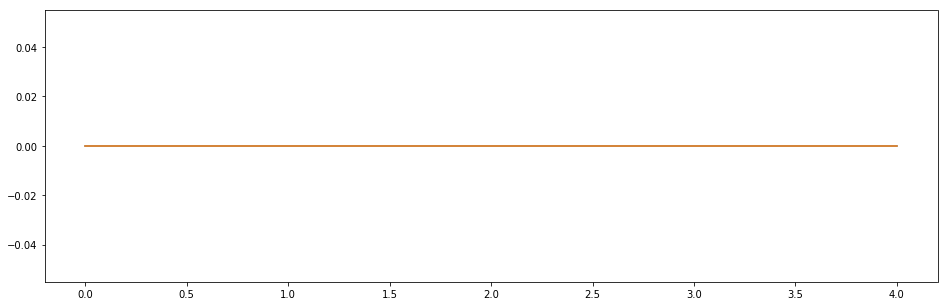

In [229]:
n_trials = 5

tr_errs, val_errs = np.zeros(n_trials), np.zeros(n_trials)

for i in range(n_trials):
    a,b = train_loop(Xtr, Ytr, Xval, Yval, 
                     h, lrate, 
                     vis='', #no visualization
                     nEpochs=100,
                     ϵ=1e-8)
    tr_errs[i], val_errs[i] = a[-1], b[-1]

plt.figure(figsize=(16,5))
plt.plot(tr_errs, label="training error")
plt.plot(val_errs, label="validation error")
plt.title("Error")
plt.legend()
plt.show()

In this scenario, the algorithm always converges perfectly. As we used a logistic regression which is smooth, we always get to a solution. Is this solution always the same and the best one? This depends on the convexity of the model. Here it does.

### Impact of the learning rate.

Let us change the learning rate in the range of values $\text{lrate} = \{2, 0.2, 0.02, 0.002\}$. For each of these values, we will run the training procedure 5 times and observe the average behaviour on training and validation.

In [232]:
nEpochs = 40
trials = 5
lrates = [2, 0.2, 0.02, 0.002]
plot_data_lr = np.zeros((2, trials, len(lrates), nEpochs*1000))
h = 7
for j, lrate in enumerate(lrates):
    print('LR = %f' % lrate)
    for i in range(trials):
        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='never', nEpochs=nEpochs)
        plot_data_lr[0, i, j, :] = tr_error
        plot_data_lr[1, i, j, :] = val_error

LR = 2.000000
LR = 0.200000
LR = 0.020000
LR = 0.002000


Text(0, 0.5, 'training error')

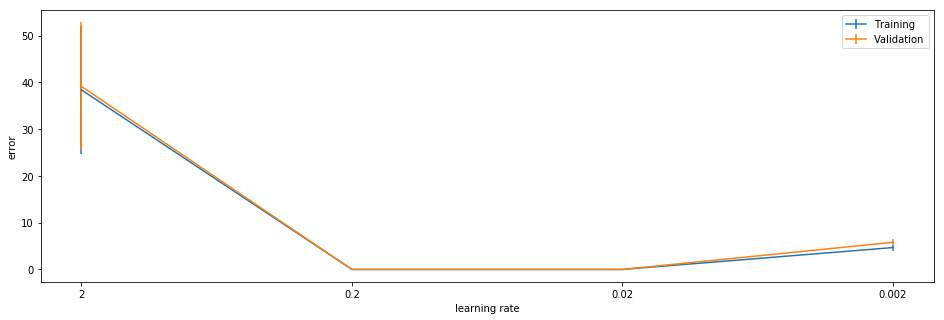

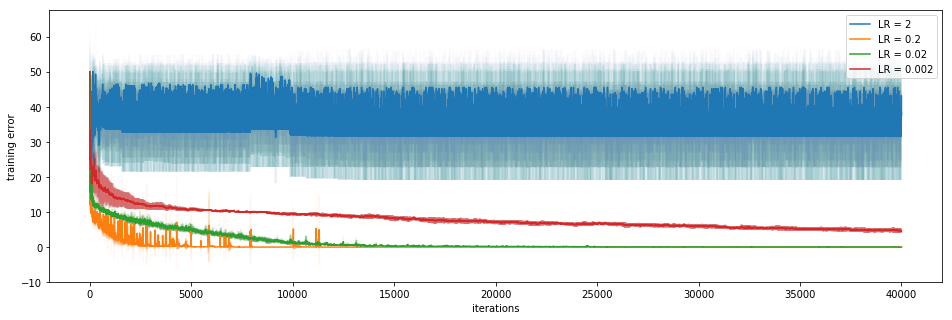

In [235]:
plt.figure(figsize=(16, 5))
plt.errorbar(np.arange(len(lrates)), plot_data_lr[0, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Training')
plt.errorbar(np.arange(len(lrates)), plot_data_lr[1, :, :, -1].mean(axis=0), yerr=plot_data_lr[0, :, :, -1].std(axis=0), label='Validation')
plt.xticks(np.arange(len(lrates)), lrates)
plt.xlabel('learning rate')
plt.ylabel('error')
plt.legend()

# Plot the evolution of the training loss for each learning rate
plt.figure(figsize=(16, 5))
for j, lrate in enumerate(lrates):
    x = np.arange(plot_data_lr.shape[3])
    # Mean training loss over trials
    y = plot_data_lr[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_lr[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label='LR = ' + str(lrate))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')

We can deduce that:
- If the learning rate is too high, the algorithm may not converge.
- There may be an optimal range of values. If it is too low: the error might not decrease "as much as it could" (it's almost like we stopped taking gradient steps, even though there might be genuine directions of descent available)
- The speed is impacted: the convergence is reached from 15.000 iterations up until never. (15,000; 40,000). 

### Impact on the number of hidden layers
**The number of hidden units:**

We will pick the best learning rate from our previous trial: $lrate = 0.02$ and change the number of hidden units $h _i \{1, 2, 5, 7, 10, 100\}$. For each of these values run the training procedure 5 times and observe the average behaviour on training and validation.

h = 1.000000
h = 2.000000
h = 5.000000
h = 7.000000
h = 10.000000
h = 100.000000


Text(0, 0.5, 'training error')

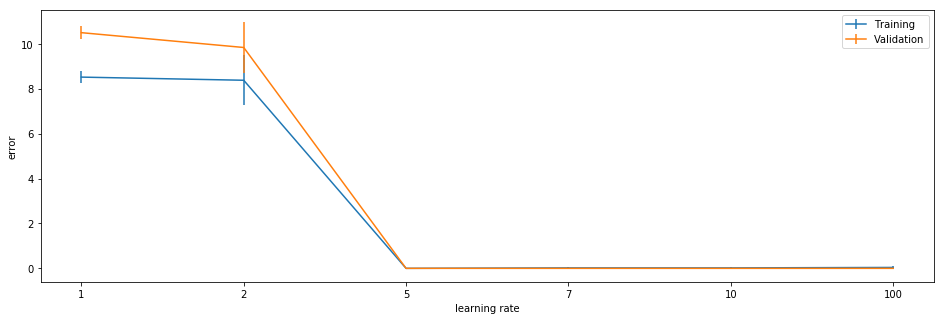

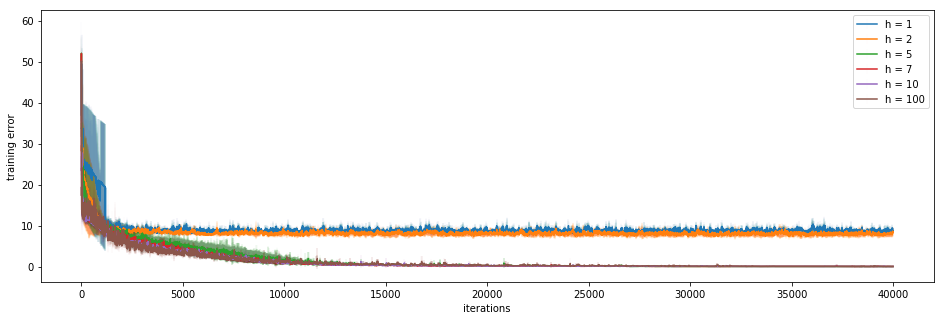

In [236]:
###################################################
# Analysis
###################################################
nEpochs = 40
trials = 5
lrate = 0.02
hh = [1, 2, 5, 7, 10, 100]
plot_data_h = np.zeros((2, trials, len(hh), nEpochs*1000))

for j, h in enumerate(hh):
    print('h = %f' % h)
    for i in range(trials):
        tr_error, val_error = train_loop(Xtr, Ytr, Xval, Yval, h, lrate, vis='never', nEpochs=nEpochs)
        plot_data_h[0, i, j, :] = tr_error
        plot_data_h[1, i, j, :] = val_error

###################################################
# Plotting
###################################################
plt.figure(figsize=(16, 5))
plt.errorbar(np.arange(len(hh)), plot_data_h[0, :, :, -1].mean(axis=0), yerr=plot_data_h[0, :, :, -1].std(axis=0), label='Training')
plt.errorbar(np.arange(len(hh)), plot_data_h[1, :, :, -1].mean(axis=0), yerr=plot_data_h[0, :, :, -1].std(axis=0), label='Validation')
plt.xticks(np.arange(len(hh)), hh)
plt.xlabel('number of hidden units')
plt.ylabel('error')
plt.legend()

# Plot the evolution of the training loss for each learning rate
plt.figure(figsize=(16, 5))
for j, h in enumerate(hh):
    x = np.arange(plot_data_h.shape[3])
    # Mean training loss over trials
    y = plot_data_h[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_h[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x, y, yerr=ebar, label='h = ' + str(h))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')
plt.show()

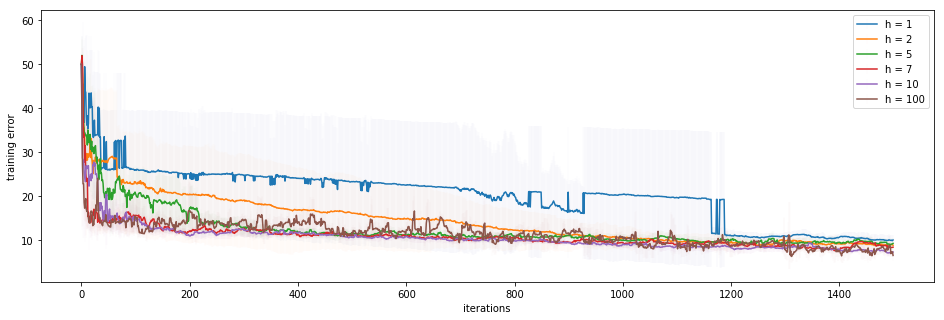

In [281]:
# Let us zoom in:
zoom = 1500 # iterations to monitor
plt.figure(figsize=(16, 5))
for j, h in enumerate(hh):
    x = np.arange(plot_data_h.shape[3])
    # Mean training loss over trials
    y = plot_data_h[0, :, j, :].mean(axis=0)
    # Standard deviation over trials
    ebar = plot_data_h[0, :, j, :].std(axis=0)
    # Plot
    markers, caps, bars = plt.errorbar(x[:zoom], y[:zoom], yerr=ebar[:zoom], label='h = ' + str(h))
    # Make the error bars transparent
    [bar.set_alpha(0.01) for bar in bars]
plt.legend()
plt.xlabel('iterations')
plt.ylabel('training error')
plt.show()

From this we can conclude the following.
- The algorithm always converges.
- When there are not enough neurons in the hidden layer, the training error does not reach 0.
- It seems the speed is greatly increased with the number of neurons in the hidden layer, but the complexity of the problem at hand being limited, we observe that there isn't much benefit in using 100 hidden units instead of only 7.
- Eventually, we must point out there is a tradeoff between accuracy and performance: The higher the number of units in the hidden layer, the higher the number of parameters to compute, the longer it takes to compute the gradient, the longer we have to wait for the result.

# Part 2 - Building blocks of a CNN

This part introduces typical CNN building blocks, such as ReLU units and linear filters. For a motivation for using CNNs over fully-connected neural networks, see [[Le Cun, et al, 1998]](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).


## Install PyTorch

In [246]:
# Install PyTorch (http://pytorch.org/)
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
False


## Convolution

A feed-forward neural network can be thought of as the composition of number of functions 
$$
f(\mathbf{x}) = f_L(\dots f_2(f_1(\mathbf{x};\mathbf{w}_1);\mathbf{w}_2)\dots),\mathbf{w}_{L}).
$$
Each function $f_l$ takes as input a datum $\mathbf{x}_l$ and a parameter vector $\mathbf{w}_l$ and produces as output a datum $\mathbf{x}_{l+1}$. While the type and sequence of functions is usually handcrafted, the parameters $\mathbf{w}=(\mathbf{w}_1,\dots,\mathbf{w}_L)$ are *learned from data* in order to solve a target problem, for example classifying images or sounds.

In a *convolutional neural network* data and functions have additional structure. The data $\mathbf{x}_1,\dots,\mathbf{x}_n$ are images, sounds, or more in general maps from a lattice$^1$ to one or more real numbers. In particular, since the rest of the practical will focus on computer vision applications, data will be 2D arrays of pixels. Formally, each $\mathbf{x}_i$ will be a $M \times N \times K$ real array of $M \times N$ pixels and $K$ channels per pixel. Hence the first two dimensions of the array span space, while the last one spans channels. Note that only the input $\mathbf{x}=\mathbf{x}_1$ of the network is an actual image, while the remaining data are intermediate *feature maps*.

The second property of a CNN is that the functions $f_l$ have a *convolutional structure*. This means that $f_l$ applies to the input map $\mathbf{x}_l$ an operator that is *local and translation invariant*. Examples of convolutional operators are applying a bank of linear filters to $\mathbf{x}_l$. 

In this part we will familiarise ourselves with a number of such convolutional and non-linear operators. The first one is the regular *linear convolution* by a filter bank. We will start by focusing our attention on a single function relation as follows:
$$
 f: \mathbb{R}^{M\times N\times K} \rightarrow \mathbb{R}^{M' \times N' \times K'},
 \qquad \mathbf{x} \mapsto \mathbf{y}.
$$

$^1$A two-dimensional *lattice* is a discrete grid embedded in $R^2$, similar for example to a checkerboard.

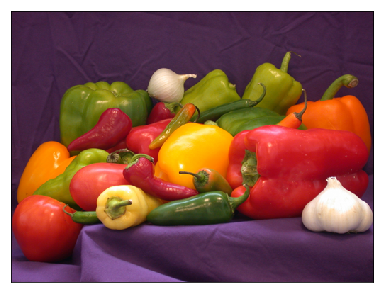

In [324]:
import matplotlib.pyplot as plt
import numpy as np
# from scipy.misc import imread
from matplotlib.pyplot import imread
import torch
import torchvision

# Download an example image
!wget -q http://www.di.ens.fr/willow/teaching/recvis/assignment3/images/peppers.png
# Read the image 
pic = imread('peppers.png')#reading with matplotlib already scales values between 0 and 1
# Visualize the input x
fig = plt.figure(figsize=(16,5))
ax = fig.gca()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(pic)
plt.show()
# Convert to torch tensor
x = torch.from_numpy(pic).permute(2, 0, 1).float() # the axis 2 becomes 0, 0 becomes 1 and 1 becomes 2
# Prepare it as a batch
x = x.unsqueeze(0)
# Print the size of x. Third dimension (=3) corresponds to the R, G, B channels
print("shape of the picture:", pic.shape)
print("shape of the tensor:", x.shape)

Next, we create a convolutional layer with a bank of 10 filters of dimension $5 \times 5 \times 3$ whose coefficients are initialized randomly. This uses the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) module from PyTorch:

In [287]:
# Create a convolutional layer and a random bank of linear filters
conv = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=0, bias=False)
print(conv.weight.size())

torch.Size([10, 3, 5, 5])


**Remark:** You might have noticed that the `bias` argument to the `torch.nn.Conv2d` function is the empty matrix `false`. It can be otherwise used to pass a vector of bias terms to add to the output of each filter.

Note that `conv.weight` has four dimensions, packing 10 filters. Note also that each filter is not flat, but rather a volume containing three slices. The next step is applying the filter to the image.

In [288]:
# Apply the convolution operator
y = conv(x)
# Observe the input/output sizes
print(x.size())
print(y.size())

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 380, 508])


The variable `y` contains the output of the convolution. Note that the filters are three-dimensional. This is because they operate on a tensor $\mathbf{x}$ with $K$ channels. Furthermore, there are $K'$ such filters, generating a $K'$ dimensional map $\mathbf{y}$.

We can now visualise the output `y` of the convolution. In order to do this, use the `torchvision.utils.make_grid` function to display an image for each feature channel in `y`:

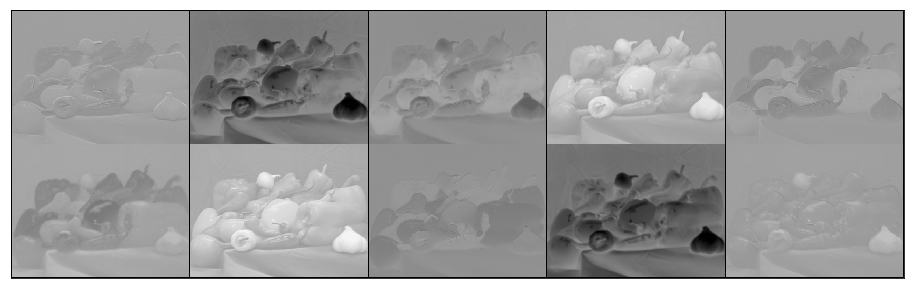

In [304]:
# Visualize the output y
def vis_features(y, title=""):
    # Organize it into 10 grayscale images
    out = y.permute(1, 0, 2, 3)
    # Scale between [0, 1]
    out = (out - out.min().expand(out.size())) / (out.max() - out.min()).expand(out.size())
    # Create a grid of images
    out = torchvision.utils.make_grid(out, nrow=5)
    # Convert to numpy image
    out = np.transpose(out.detach().numpy(), (1, 2, 0))
    # Remove grid
    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # Show
    plt.imshow(out)
    if title != "":
        plt.title(title)
    plt.show()

vis_features(y)

So far filters preserve the resolution of the input feature map. However, it is often useful to *downsample the output*. This can be obtained by using the `stride` option in `torch.nn.Conv2d`:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 24, 32])


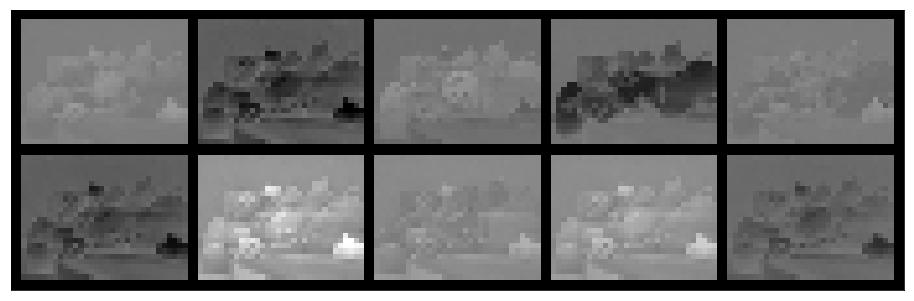

In [296]:
# Try again, downsampling the output
conv_ds = torch.nn.Conv2d(3, 10, kernel_size=5, stride=16, padding=0, bias=False)
y_ds = conv_ds(x)
print(x.size())
print(y_ds.size())
vis_features(y_ds)

Applying a filter to an image or feature map interacts with the boundaries, making the output map smaller by an amount proportional to the size of the filters. If this is undesirable, then the input array can be padded with zeros by using the `pad` option:

torch.Size([1, 3, 384, 512])
torch.Size([1, 10, 384, 512])


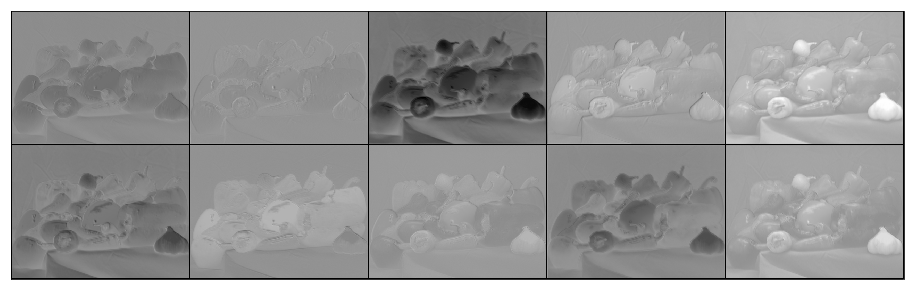

In [297]:
# Try padding
conv_pad = torch.nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2, bias=False)
y_pad = conv_pad(x)
print(x.size())
print(y_pad.size())
vis_features(y_pad)

Let us sum it up and design a filter by hand:

0. How do kernels apply to images? A good visualization of kernels for images [can be found here](http://setosa.io/ev/image-kernels/).
1. Let us create a simple convolution filter, for example a [Laplacian operator](http://aishack.in/tutorials/image-convolution-examples/) $(3,3)$ ( actually just a common discretization for it). It is useful to detect edges, but is sensible to noise. We could smooth the image with a gaussian filter first for best results.
2. Duplicate it 3 times and reshape it so that it fits the torch format : $(1,3,3,3)$ meaning there is 1 filter with 3 channels of size $(3,3)$.
3. Create another torch tensor.
    - there are 3 input channels.
    - This time we will use only 1 output channel: the sum of the filtered images for each channel.
    - kernel size is 3 (since we have begun with a $(3,3)$ matrix).
    - basic stride and padding.
    - set its weight matrix with our filter.

input tensor shape: torch.Size([1, 3, 384, 512])
output tensor shape: torch.Size([1, 1, 384, 512])


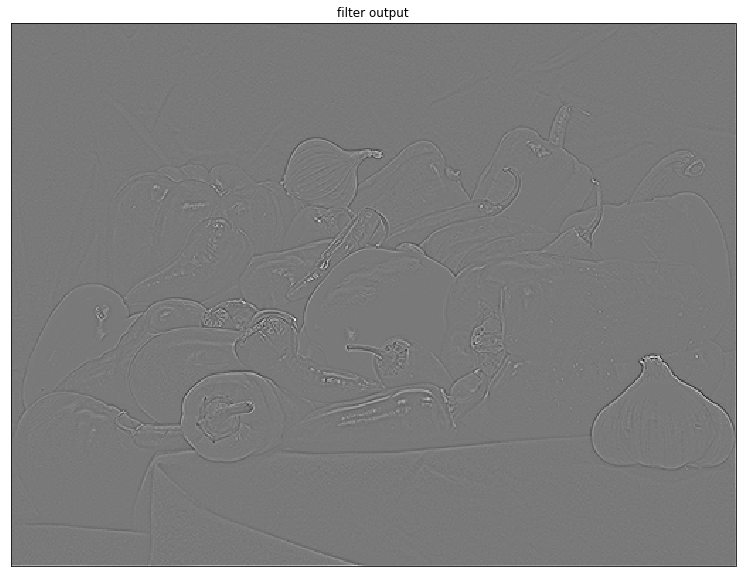

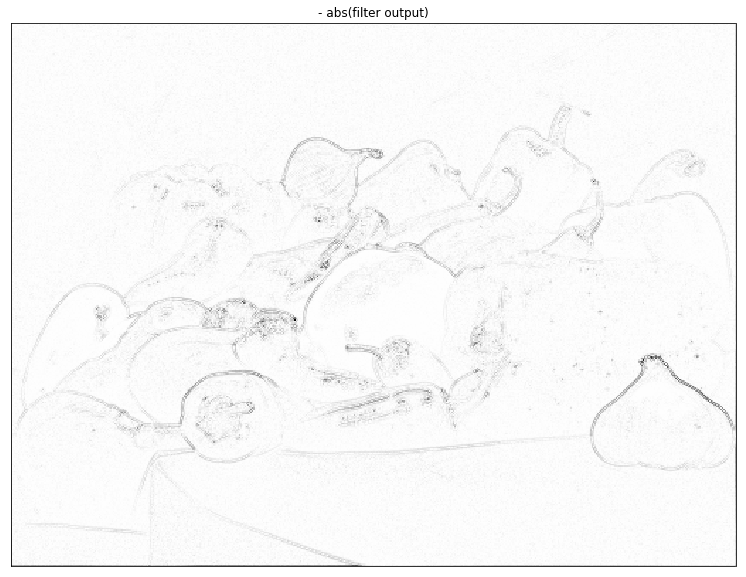

In [312]:
w = torch.FloatTensor([[0,  -1, 0 ],
                       [-1, 4, -1 ],
                       [0,  -1, 0 ]]) 
w = w.repeat(3, 1).reshape(1, 3, 3, 3)
conv_lap = torch.nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1, bias=False)
conv_lap.weight = torch.nn.Parameter(w) 
y_lap = conv_lap(x)
print("input tensor shape:", x.size())
print("output tensor shape:", y_lap.size())

vis_features(y_lap, title='filter output')
vis_features(-torch.abs(y_lap), title='- abs(filter output)')


## Non-linear activation functions

The simplest non-linearity is obtained by following a linear filter by a *non-linear activation function*, applied identically to each component (i.e. point-wise) of a feature map. The simplest such function is the *Rectified Linear Unit (ReLU)*
$$
  y_{ijk} = \max\{0, x_{ijk}\}.
$$
This function is implemented by [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/nn.html#torch.nn.ReLU). 

1. Create a gradient filter, and replicate it for the 3 channels
2. Concatenate it with its opposite (gradient and opposite of gradients) -> We will have 2 ouput images, concatenated.
3. Apply the ReLU filter. It keeps only zones with positive values (high gradient, not only in absolute value).


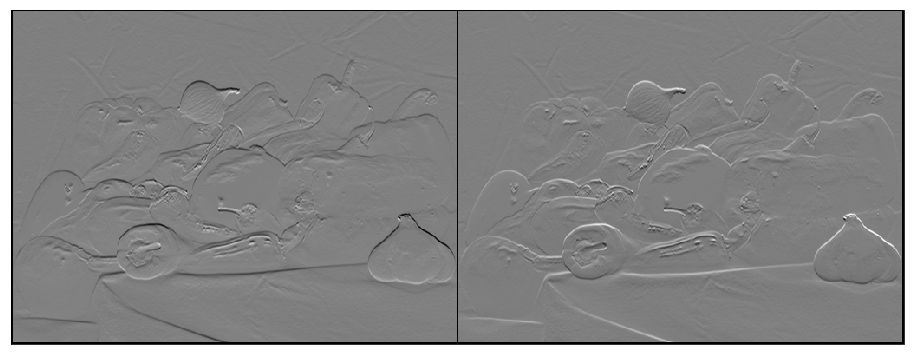

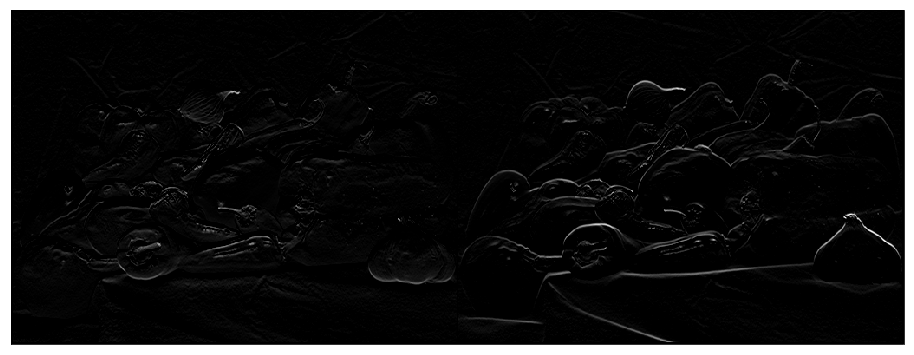

In [313]:
w = torch.FloatTensor([[1], [0], [-1]]).repeat(1, 3, 1, 1)
w = torch.cat((w, -w), 0)

conv = torch.nn.Conv2d(3, 2, kernel_size=(3, 1), stride=1, padding=0, bias=False)
conv.weight = torch.nn.Parameter(w)
relu = torch.nn.ReLU()

y = conv(x)
z = relu(y)

vis_features(y)
vis_features(z)

## Pooling
There are several other important operators in a CNN. One of them is *pooling*.  A pooling operator operates on individual feature channels, coalescing nearby feature values into one by the application of a suitable operator. Common choices include max-pooling (using the max operator) or sum-pooling (using summation). For example, *max-pooling* is defined as:
$$
   y_{ijk} = \max \{ y_{i'j'k} : i \leq i' < i+p, j \leq j' < j + p \}
$$
Max-pooling is implemented by [`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d).

This is a form of downsampling. To illustrate this, let us apply max-pooling, and then visualize the result: For each square of `param`size, the whole patch takes the value of the maximum value pixel (for all 3 channels).

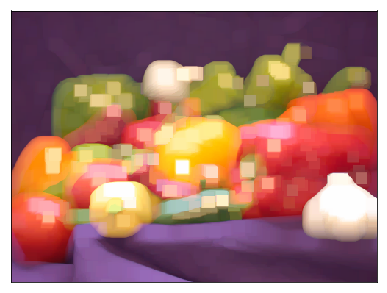

In [323]:
param = 15
mp = torch.nn.MaxPool2d(param, stride=1)
y = mp(x)
fig = plt.figure(figsize=(16,5))
ax = fig.gca()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(y.squeeze().permute(1, 2, 0).numpy()) #squeeze removes the dimensions of size 1
plt.show()

In [325]:
#Free some space in memory
del x, y, w, conv, mp, pic, conv_lap

# Part 3 - Training a CNN

This part is an introduction to using PyTorch for training simple neural net models. CIFAR-10 dataset will be used.

## Imports

In [25]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

## Parameters

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment. 

In [2]:
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

## Warmup





It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

In [3]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the dataset from the internet
dataset = 'cifar10'
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


### Let us visualize the data

[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

size of one batch of the training data:  torch.Size([64, 3, 32, 32])


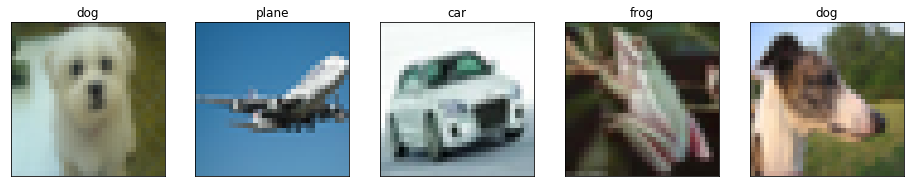

In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get one batch of images and labels
pictures, labels = iter(train_loader).next() #there are several batches of images, each of size batch_size
print("size of one batch of the training data: ", pictures.shape)

# Plot just a few pictures with their labels
n_plots = 5
fig, axes = plt.subplots(1, n_plots, figsize=(16,5))
for i in range(n_plots):
    picture = pictures[i]
    picture = picture / 2 + 0.5 # unnormalize
    picture = picture.numpy()
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(classes[labels[i].item()])
    axes[i].imshow(np.transpose(picture, (1, 2, 0))) #reorganize channels, height and width.


## Training a Convolutional Network on CIFAR-10




Start by running the provided training code below. By default it will train on CIFAR-10 for 10 epochs (passes through the training data) with a single layer network. The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`. Note the decrease in training loss and corresponding decrease in validation errors.

In [11]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(network):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
# Single layer network architecture

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.num_inputs = num_inputs
        
    def forward(self, input):
        input = input.view(-1, self.num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

In [368]:
# Train
network = Net(3072, 10)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 11):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.311403
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.865209
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.617291
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.132321
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.772744
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.745877
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.755463
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.633350


C:\Users\Benjamin\Anaconda3\envs\benJ_1\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.7765, Accuracy: 19792/50000 (39%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.839486
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.841853
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.752285
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.638149
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.633029
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.720130
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.756306
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.772130

Test set: Average loss: 1.7281, Accuracy: 20630/50000 (41%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.862545
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.914221
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.533532
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.543482
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.478208
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.095134
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.759551
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.660877

Test set: Average loss: 1.7132, Accuracy: 20861/50000 (41%)

Train Epoch: 4 [0/50000 (0

### Going Convolutionnal

43% accuracy (stable over the last epochs) is respectable, better than the 10% we would get by guessing at random anyway... Yet it is far from being great.


Based on [this official pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolution-neural-network), let us create our own convolutional network architecture.

1. Layer:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
2. Layer:
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling.
3. Layer:
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
4. Layer:
  - Linear layer to `num_outputs` = 10 output units (because we have 10 classes, and want the probability for each one)

In [13]:
# Customized CNN

class ConvNet(nn.Module):
    def __init__(self, num_outputs):
        super(ConvNet, self).__init__()
        
        #General parameters
        self.num_outputs = num_outputs
        
        #Convolutional operations
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5, padding=0)
        
        #Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        #Linear operations
        self.lin1 = nn.Linear(128 * 5 * 5, 64)
        self.lin2 = nn.Linear(64, self.num_outputs)
        
        #Non-linearity function
        self.nlf = torch.tanh
        
    def forward(self, x):
        
        #Layer 1 -> some convolutions
        output = self.conv1(x)
        output = self.nlf(output)
        output = self.pool(output)
        
        #Layer 2 -> a lot more convolutions
        output = self.conv2(output)
        output = self.nlf(output)
        output = self.pool(output)
        
        output = output.view(-1, 128 * 5 * 5) # Volume is size_ofoutputchannels of last kernel*surface of the kernel
        # Alternatively, one could do: output = output.view(batch_size, -1), (to avoid bad OO programming)
        
        #Layer 3 -> big Linear Layer
        output = self.lin1(output)
        output = self.nlf(output)
        
        #Layer 4 -> small Linear layer
        output = self.lin2(output)
        
        return output

### Why non-linearities ?

If we used only linear functions, no matter how many layers we put in the model, the weights could be concatenated to make a single-layer perceptron with the same predictions abilities. [See this](https://www.coursera.org/lecture/neural-networks-deep-learning/why-do-you-need-non-linear-activation-functions-OASKH)

Non-linearities allows to look for solutions in a more complex space than "linear transformations".

### Let us train our new CNN network
Train the CNN for 20 epochs on the CIFAR-10 training set.

In [15]:
network = ConvNet(10)
optimizer = optim.SGD(network.parameters(), lr=lr)
for epoch in range(1, 21):
    train(epoch, network)
    test(network)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.323165
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.195924
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.008188
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.084782
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.834754
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.799524
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.893049
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.817917


C:\Users\Benjamin\Anaconda3\envs\benJ_1\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.7830, Accuracy: 18633/50000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.859280
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.747777
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.702594
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.465779
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.573185
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.707274
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.657686
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.729794

Test set: Average loss: 1.5686, Accuracy: 22088/50000 (44%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.590386
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.587329
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.639578
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.529016
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.425357
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.258406
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.219884
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.686208

Test set: Average loss: 1.4923, Accuracy: 23545/50000 (47%)

Train Epoch: 4 [0/50000 (0

Train Epoch: 19 [44800/50000 (90%)]	Loss: 1.015456

Test set: Average loss: 0.7972, Accuracy: 36140/50000 (72%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 1.058704
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.829112
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.571306
Train Epoch: 20 [19200/50000 (38%)]	Loss: 1.120823
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.664358
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.678517
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.660858
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.914910

Test set: Average loss: 0.7831, Accuracy: 36398/50000 (72%)



In [17]:
# Let us save the model and its parameters for later use:
path = "model.txt"
torch.save(network, path) #can be loaded with network = torch.load(path)

C:\Users\Benjamin\Anaconda3\envs\benJ_1\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Although still not perfect, the accuracy is much better (72% vs 43%). Maybe running a few more epochs would make it even better.

### Visualizing the first convolutional layers
Let us plot the first convolutional layer weights as images after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils)
[#3](https://github.com/facebookresearch/visdom/issues/12)
[#4](https://github.com/facebookresearch/visdom/blob/master/example/demo.py))


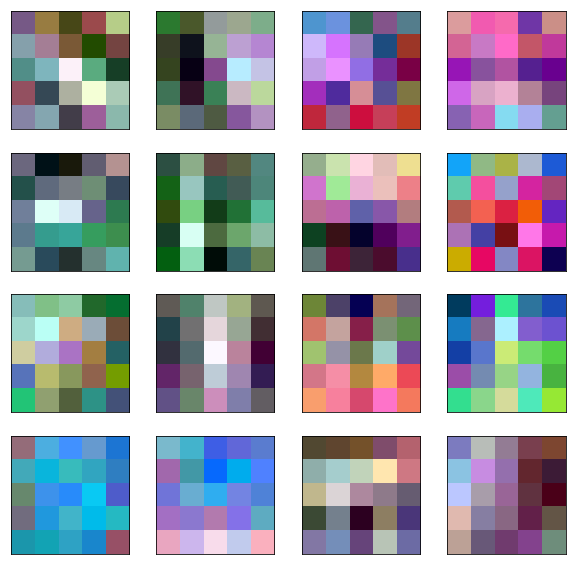

In [105]:
#################### Retrieve the weights
w = network.conv1.weight.data.permute(0, 2, 3, 1)
print("shape of the weight matrix of conv1: ", w.shape)

#################### Visualize it with a visualization module from Facebook Research: visdom

#### Create a session
# !pip install visdom
from visdom import Visdom
port = 8097
host_name = "http://localhost"
# !python -m visdom.server -p 8097 #better to start it from a CLI (not from the jupyter notebook)
# Open a tab on your internet browser and navigate to "http://localhost:8097/"
vis = Visdom(port=port, server=host_name)

#### Create the visualization
vis.text('This is what a print does') # create 
window = vis.images(network.conv1.weight.data)
# You can check the image has appeared on "http://localhost:8097/"


#################### Visualize it myself
n_plots = w.shape[0]
line_length = int(n_plots**.5)
fig, axes = plt.subplots(line_length, line_length, figsize=(10,10))
for i in range(n_plots):
    #Get the ith picture
    picture = w[i].numpy()
    
    # un-normalize it
    min_pic, max_pic = np.min(picture), np.max(picture)
    picture = (picture - min_pic) / (max_pic - min_pic)
    
    # plot it
    row = i%line_length
    column = i//line_length
    axes[row, column].grid(False)
    axes[row, column].set_xticks([])
    axes[row, column].set_yticks([])
    axes[row, column].imshow(picture)

Visdom visualization
![conv1_weights_visdom_visualization](https://drive.google.com/uc?export=view&id=1QNicOjKB9WNmPoUqAOhEQcLpCTUAsrTW)

### Dimensionnality of the optimization problem

What is the dimensionality of the weights at each layer? How many parameters are there in total in this CNN architecture?

1. *conv1* is of size $(16, 3, 5, 5) \rightarrow 1\,200$ parameters to be learnt.
2. *conv2* is of size $(128, 16, 5, 5) \rightarrow 51\,200$ parameters to be learnt.
3. *lin1* is of size $(128*5*5, 64) \rightarrow 204\,800 + 64$ parameters to be learnt.
4. *lin2* is of size $(64, 10) \rightarrow 640 + 10$ parameters to be learnt.

Meaning there is a **grand total of $ 1\,200 + 51\,200 + 204\,864 + 650 = 257\,914$** parameters to be learnt.

## AUTHORSHIP STATEMENT

Despite using stackoverflow, pytorch and matplotlib documentation, and explanations on the $\star$ operator, I declare that the preceding work was the result of my own efforts.

Benjamin LAZARD